# AI Lab Assignment 4

# 3. Text processing and unbalanced data (4.5 points)

In [2]:
import pandas as pd

df = pd.read_csv("train.tsv", sep='\t', index_col="PhraseId")
pd.set_option('display.max_colwidth', None)
df.head(2)

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
2,1,A series of escapades demonstrating the adage that what is good for the goose,2


We will use a dataset to predict the sentiment of some text from tagged phrases.
Labels for sentiments are:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

More information [here](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).


Throughout this exercise we will see different ways of processing the text and balancing the classes to be learned.

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df[["Phrase", "Sentiment"]], random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment

**Basic Models**

We are going to start with a *pipe* of very basic models and see if they have any issues.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

count_vectorizer = CountVectorizer(max_features=1000)
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
pipe = make_pipeline(count_vectorizer,decision_tree)

In [5]:
from sklearn.metrics import accuracy_score
X_train_original =  train.Phrase
y_train_original =  train.Sentiment

def get_accuracy(pipe, X_train=X_train_original, y_train=y_train_original):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test),3)

In [10]:
get_accuracy(pipe)

0.515

Let's see which classes are actually being predicted

In [8]:
# Training labels
round(pd.Series(y_train).value_counts(normalize=True),2)

2    0.51
3    0.21
1    0.17
4    0.06
0    0.04
Name: Sentiment, dtype: float64

In [7]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [11]:
# Predicted classes
y_pred = pipe.predict(X_test)
round(pd.Series(y_pred).value_counts(normalize=True),2)

2    0.97
3    0.03
dtype: float64

That is: being an unbalanced problem, the prediction is clearly biased towards one of the classes.

This can also be seen by analyzing the **confusion matrix**

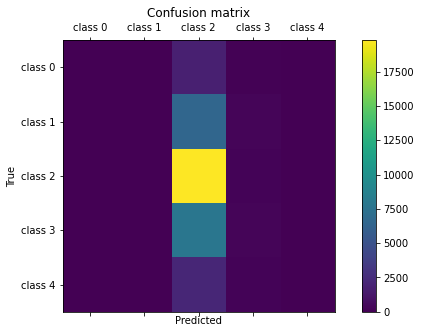

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(pipe, title='Confusion matrix'):
    ticks = np.unique(y_test)
    labels = [('class '+ str(tick)) for tick in ticks]
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(pipe)

## Changing models and data processing

Analyze if any of the other models seen in previous exercises avoid this problem of unbalanced classes.

For example, in the following cell we changed the decision tree classifier and used a KNN instead.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
pipe_knn = make_pipeline(count_vectorizer,knn)
get_accuracy(pipe_knn)

0.564

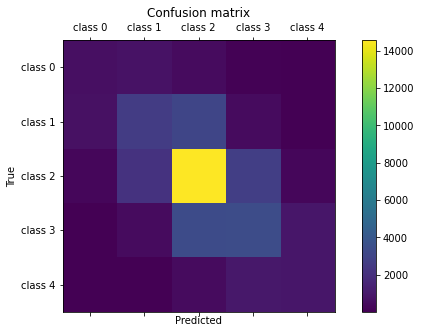

In [11]:
plot_confusion_matrix(pipe_knn)

When analyzing this confussion matrix, we can rapidly say that these results are better than the ones obtained with the decision tree. The reason behind this statement is that this time, the matrix has higher values in the diagonal.

Each tile located in the diagonal correspond to correct predictions of a class. Therefore, the higher the values in the diagonal, the better the classifier is predicting. 

In these plots, higher values are represented with lighter colors.

### Explore multiple models and reply to the following questions:

* Which model gives better results?
* Are there any parameters of the models that are particularly effective in avoiding imbalance?

Note: include as many cells as you need to show the code you used to answer these questions.

In [13]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=1000,)
pipe_log = make_pipeline(count_vectorizer,log)
get_accuracy(pipe_log)


0.588

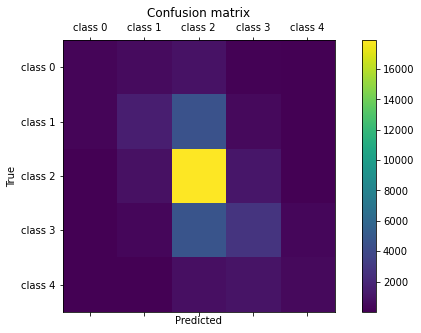

In [14]:
plot_confusion_matrix(pipe_log)

The confussion matrix shows better results than the ones obtained with the decision tree and with the Knn classifier, although the difference is just a 2%. Running MLPClasiffiers is not feasible because it takes too long for making a (reduced) search in its parameter space.

We are going to try a RandomForestclassifier as proposed in https://elitedatascience.com/imbalanced-classes for unbalanced data sets

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

pipe_neuron = make_pipeline(count_vectorizer,clf)
get_accuracy(pipe_neuron)

0.606

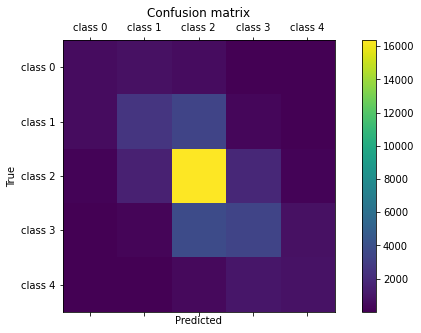

In [14]:
plot_confusion_matrix(pipe_neuron)

Once again, we do not get considerably better results. We are stuck in a 60% acurracy. Now we will try varying the depth of a decision tree.

In [22]:
x,y = [],[]

for depth in range(5,200,5):
    clf = DecisionTreeClassifier(max_depth=depth)
    pipe_neuron = make_pipeline(count_vectorizer,clf)
    x.append(depth)
    y.append(get_accuracy(pipe_neuron))

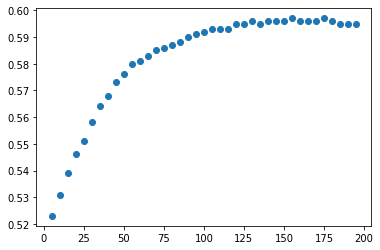

In [23]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()

We see that as we increase the depth, the success rate grows but never above the 60%. As it has happened with other classifiers, 60% seems a barrier. Moreover, increasing the depth of a decision tree is in general a bad choice as it leads to overfitting. 

Just to try a few more things, let's vary the hyper-parameters `criterion` and `splitter` for a depth of d=25.

In [27]:
score = y[24]
clf = DecisionTreeClassifier(max_depth=25, splitter='random')
pipe = make_pipeline(count_vectorizer,clf)
print(f" Difference of scores: {get_accuracy(pipe)-score}")

 Difference of scores: -0.04599999999999993


In [28]:
clf = DecisionTreeClassifier(max_depth=25, criterion='entropy')
pipe = make_pipeline(count_vectorizer,clf)
print(f" Difference of scores: {get_accuracy(pipe)-score}")

 Difference of scores: -0.04499999999999993 better


As we see, varying those parameters results in almost no change. In the next exercise we will experiment with a few more classifiers.

### Data Processing

The first step used in the *pipe* above is very simple: it counts how many times each term appears. Also, it has been limited to a maximum of 1000 dimensions. Try other ways of processing the text and discuss the differences. 

As an example, the following cell uses a method that considers the frequency of terms ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) ). The documentation shows that it allows several configurations (removing accents, changing to lowercase, performing more complex transformations, removing common words, etc.).

0.605


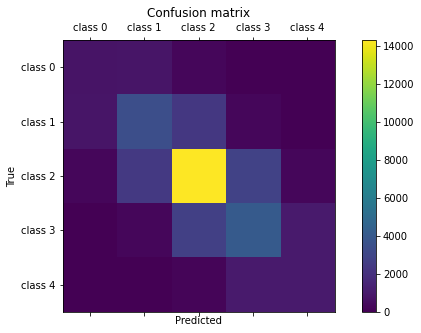

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

knn = KNeighborsClassifier(n_neighbors=1)
tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

Try various classifiers and settings for text processing and answer the following questions:

* According to your experiments, which processing step has the greatest effect on the results: the classifier or the text processing?
* Have you found any type of processing that always improves the results? What hypothesis would you propose to explain this behavior?

# Varying the classifiers

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import *

0.638


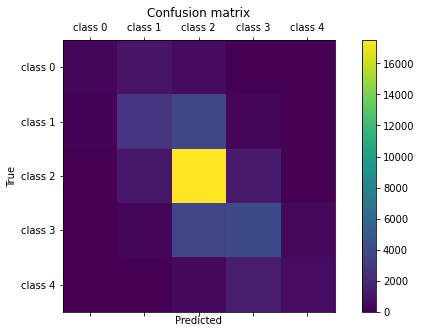

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

clf = LogisticRegression(max_iter=1000,multi_class='multinomial') 
# multi_class='multinomial' because our class is not binary 

tfidf_vectorizer = TfidfVectorizer()
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

The logistic classifier gives a good starting point: 63%. This score is above the barrier we had encountered in the previous exercise. Nevertheless, we will try other classifiers.

We tried using a neural network, but it took more than an hour to execute. 

Based on the results from the previous exercise, we will try again Knn with different values of K. This is motivated by the fact that it gave quite better results than a decision tree and its execution time is small enough to allow us try several values for the hyperparameters.

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

for k in [1,5,10,15,20]:
    clf = KNeighborsClassifier(n_neighbors=k)
    tfidf_vectorizer = TfidfVectorizer()
    pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
    print(f"Trying {k} neigbours. Acurracy = {get_accuracy(pipe_tfidf)}")

Trying 1 neigbours. Acurracy = 0.605
Trying 5 neigbours. Acurracy = 0.619
Trying 10 neigbours. Acurracy = 0.594
Trying 15 neigbours. Acurracy = 0.557
Trying 20 neigbours. Acurracy = 0.537


Although K=5 seems to give better results, there is no much difference between the different values of K.  Now, we will try with several Naive Bayes classifiers.

0.593


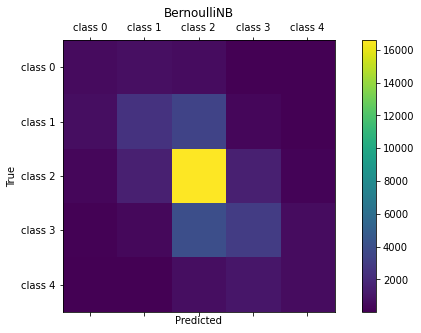

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import *
clf = BernoulliNB()
tfidf_vectorizer = TfidfVectorizer()
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf,"BernoulliNB")


The result is does not come as a suprise: once again, a result around 60%

0.587


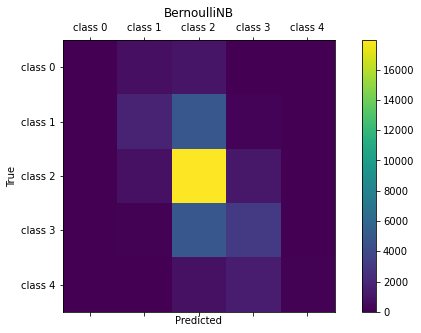

In [14]:
from sklearn.naive_bayes import *
clf = MultinomialNB()
tfidf_vectorizer = TfidfVectorizer()
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf,"BernoulliNB")

0.579


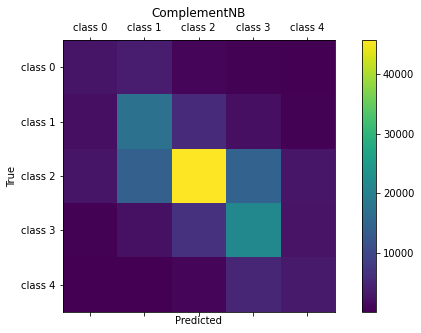

In [80]:
from sklearn.naive_bayes import *
clf = ComplementNB()
tfidf_vectorizer = TfidfVectorizer()
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf, "ComplementNB")

This output is quite intersting. We are still around the barrier of the 60% but the confussion matrix seems to be more diagonal. That is to say, we are getting more correct predictions for instances of class 1 and 3 as we did before. Nevertheless, it is at expense of failing more times in predictions of class 2 which is the majority class. 

We are going to cary the hyperparameters of this last classifier, the ComplementNB to observe how does the confussion matrix change.

0.54


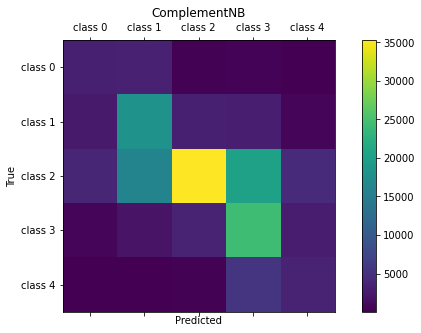

In [81]:
from sklearn.naive_bayes import *
_complementNB = ComplementNB(norm=True, alpha=0.7)
tfidf_vectorizer = TfidfVectorizer()
pipe_tfidf = make_pipeline(tfidf_vectorizer, _complementNB)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf, "ComplementNB")

### Using ComplementNB and reflecting on the term "best results"

When plotting the confussion matrix with ComplementNB as the classifiers, the first thing one notices is the green tiles. Until this point, we had not get any better than "blue" for classes other than class2. 

This classifier belongs to the Naive Bayes Classifiers. It differes from the others on how it computes the probability of an attribute given the class, that is to say, P(x_i | c). In the documentation (https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes) we find that "ComplementNB implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets". Thus it is not surprising that we get a totally different confussion matrix that with the other classifiers.

Although we get more predicitons correct for classes 1 & 3, it is at the expense of getting worse results for the predominant class. Thus the total acurracy decreases.

This leads to the next point which is the importance of defining a metric to evaluate results. In this examples, we just care about the ratio of correct predictions. Nonetheless, in other circustances we could be more interested in detecting without erros a specific class and therefore we would penalize mistakes made in predictions of that class, or, for instance, we could consider the distance from the predicted class to the real class as a penalization, etc.



# Processing the text

In this part, we will try different actions on the 'corpus' such as regulation, using a list of stop_words ... and analyze the impact on the sucess rate.

We will be using MultinomialNB as our classifier because it is the fastest (although it does not give as good results as Knn)

Our start point is an acurracy of 58%.

First we will try normalizing the text. To do so, we set the parameter strip_accent='ascii' which perfoms character normalization. On the other hand, by default all the text is converted to lowercase so we do not have to modify any parameter for that.

In [19]:
#apply character normalization
clf = MultinomialNB()
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii')
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
print(get_accuracy(pipe_tfidf))


0.587


Now we will include a list of stop_words. Stop_words are 'meaningless' words which we do not want to be taken into acoount for the analysis. We will try with the default list and with a list from https://www.ranks.nl/stopwords 

In [20]:
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
 "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", 
 "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
 "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
  "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", 
  "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", 
  "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", 
  "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", 
  "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will",
   "just", "don", "should", "now"]

This step has no impact on the acurracy. The reason behind this is that our text was already normalized

In [21]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english')
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
print(get_accuracy(pipe_tfidf))

0.59


In [22]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words=stop_words)
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
print(get_accuracy(pipe_tfidf))

0.589


Including a list of stop words just result on an improvement of a 1%. The last thing we will change is the n_gram parameter.

By default, TfidVectorizer analyzes words independently. If we fix ngram_range=(1,2), we will also consider pairs of sequent words. We will try:
-  ngram_range=(1,1) ; default one, we have already tried it
-  ngram_range=(1,2)
-  ngram_range=(1,3)
-  ngram_range=(2,3)
-  ngram_range=(2,2)


In [37]:
values =[(1,2),(1,3),(2,3),(2,2)]
for val in values:
    tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', ngram_range=val)
    pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)
    print(f"Trying ngrams={val}: acurracy={get_accuracy(pipe_tfidf)}")

Trying ngrams=(1, 2): acurracy=0.615
Trying ngrams=(1, 3): acurracy=0.614
Trying ngrams=(2, 3): acurracy=0.604
Trying ngrams=(2, 2): acurracy=0.603


The best results are obtained with ngram_range=(1,2), howver, we only get an improvement of a 2,5%. To sum up, with the three techniques we tried, we only got an improvement near to a 4%. This results encourage to try a different approach. 

# Processing the data set

In this part, we will not explore specific methods for text analysis but for unbalanced data frames in general. We will focus in resampling.

## Resampling

We are going to try to resample in order to get a more balanced data. 

Firstly we will perfom upsampling. That is to say, we will generate new data for the minority classes until all our classes have the same frequency. We will fit our classifier with this balanced data and measure the acurracy with the same tests as before. 

Secondly, we will perform downsampling. That is to say, we will generate new data for the majority class but a smaller amount than the initial; which means that the proportion of this class becomes lower in comparison with the original one.

In both cases, we need to generate new samples. For this purpose, the probability distribution function of the samples (vector of variables) is estimated using the empirical distribution function (plug-in).

Note that we change the data for fitting but we keep the same data for the validation.


### Upsampling

In [3]:
#Resample
from sklearn.utils import resample

df_majority = df[df.Sentiment==2]
n = len(df_majority)
values =[0,1,3,4]

df_upsampled = df_majority

for val in values:
    df_minority = df[df.Sentiment==val]
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=n) 

    df_upsampled = pd.concat([df_upsampled, 
                            df_minority_upsampled])
 


We have created a new data frame where all 5 classes have the same frequency (20%)

In [8]:
# We print the relative frequencies for the original data and for the upsampled
print(round(df.Sentiment.value_counts(normalize=True),2))
print(round(df_upsampled.Sentiment.value_counts(normalize=True),2))

2    0.51
3    0.21
1    0.17
4    0.06
0    0.05
Name: Sentiment, dtype: float64
2    0.2
0    0.2
1    0.2
3    0.2
4    0.2
Name: Sentiment, dtype: float64


Now, we will measure the acurracy of a MultinomialNB classifier  fitted in this new dataframe. (The test set does not change). 

Note: we use MultinomialNB as our classifier because it does not take long to execute and we can compare the results with the ones obtained for the same classifier fitted with the original data

In [62]:
#Fit with the resample
from sklearn.feature_extraction.text import TfidfVectorizer

clf = MultinomialNB()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),strip_accents='ascii')
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)

train, test = train_test_split(df[["Phrase", "Sentiment"]], random_state=0)
X_train = df_upsampled["Phrase"]
X_test = df["Phrase"]
y_train = df_upsampled["Sentiment"]
y_test = df["Sentiment"]

#Test with the original sample
print(get_accuracy(pipe_tfidf,X_train,y_train))

0.51


The acurracy obtained is 7% worse than what we got for the same classifier being fitted with the original data frame. Possibly, this is due to the fact that we have balanced the data in excess (all classes are equally represented). Now we will try downsampling, which will prevent this (having all classess equally represented in the training set) from happening again. 

### DownSampling

In [30]:
#Resample
from sklearn.utils import resample

df_majority = df[df.Sentiment==2]
n = int((1.8*len(df))//5) #To decrease by ~10% the frecuency of class Sentiment = 2

df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=n) 
df_downsampled = df_majority_downsampled

for val in [0,1,3,4]:
    df_downsampled = pd.concat([df_downsampled, 
                            df[df.Sentiment==val]])
 
# Display new class counts
round(df_downsampled.Sentiment.value_counts(normalize=True),2)

2    0.42
3    0.25
1    0.21
4    0.07
0    0.05
Name: Sentiment, dtype: float64

Again, we will measure the acurracy for a MultinomialNB classifier.

In [33]:
#Fit with the resample
from sklearn.feature_extraction.text import TfidfVectorizer

clf = MultinomialNB()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),strip_accents='ascii')
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)

train, test = train_test_split(df[["Phrase", "Sentiment"]], random_state=0)
X_train = df_downsampled["Phrase"]
X_test = df["Phrase"]
y_train = df_downsampled["Sentiment"]
y_test = df["Sentiment"]

#Test with the original sample
print(get_accuracy(pipe_tfidf,X_train,y_train))

0.726


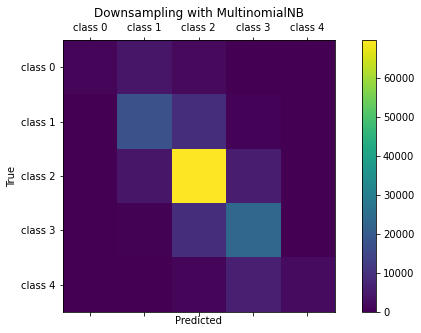

In [76]:
plot_confusion_matrix(pipe_tfidf,"Downsampling with MultinomialNB")

The acurracy has been improved a 15%. This good results, encourage us to try downsampling with a Knn classifier (the one that got best results with the original data train)

In [78]:
# We measure the acurracy using Knn as our classifier
from sklearn.feature_extraction.text import TfidfVectorizer

clf = KNeighborsClassifier(n_neighbors=1)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),strip_accents='ascii')
pipe_tfidf = make_pipeline(tfidf_vectorizer, clf)

print(get_accuracy(pipe_tfidf,X_train,y_train))

0.902


The result obtained is quite outstanding compared to the one obtained before with the original data (60%). If we plot the matrix, we clearly see a diagonal shape (which was our goal, tiles in the diagonal correspond to correct predictions).

It is worth mentioning that although the global acurracy has improved, the specific results for class 1 and 3 are quite worse than the ones obtained with a ComplementNB classifier and the original data set. We recall what we discussed about the importance of identifying the goal for each particular problem and building a metric to measure it.

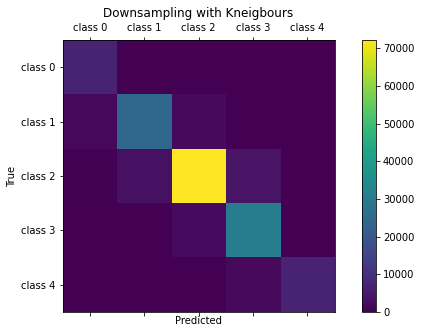

In [79]:
plot_confusion_matrix(pipe_tfidf,"Downsampling with Kneigbours")

### Conclussion on resampling

Downsampling gave better results than upsampling, possibly due to the fact that we balanced the data too much. On the other hand, we could not try downsampling with many classifiers because they took to long to execute. From the ones we tried (Naive bayes, Decision Trees, KNeighborsClassifer), KNeighborsClassifer was withouth a shadow of doubt the one that gave best results (an acurracy of 90%).

On the other hand, the execution time of such classifier was roughly 100 times what MultinomialNB (70% acurracy) took. As it usually happens, there is a trade-off between time and performance.

# Final conclussion

After varying the classifier, trying different ways of processing the test and resampling, we can conclude that the most effective techique for this particular problem was resampling. Indeed, resampling (downsampling) improved the results for all the classifiers we tried.

Having said this, we do not feel confident enough to extrapolate this conclussion to any other, even similar, problem. This was an open search where we tested different classifiers, hyperparameters configurations and techniques with one goal in mind: to obtain the highest possible accuracy.